Epoch 0


/content/center_loss.py:35: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  distmat.addmm_(1, -2, x, self.centers.t())


train loss 2.334486
train loss 2.392562
train loss 2.551649
train loss 2.842503
train loss 2.203133
train loss 2.609715
train loss 3.089579
train loss 2.949384
train loss 2.708927
train loss 2.640115
train loss 2.919596
train loss 2.320525
train loss 2.635635
test loss 10.939704

Epoch 1
train loss 2.928349
train loss 2.525225
train loss 2.442763
train loss 2.905404
train loss 2.267917
train loss 2.633641
train loss 2.649619
train loss 2.955422
train loss 2.633439
train loss 2.321357
train loss 2.089622
train loss 2.706295
train loss 2.486099
test loss 9.659485

Epoch 2
train loss 2.767286
train loss 2.473236
train loss 2.639158
train loss 2.844137
train loss 2.020753
train loss 2.638530
train loss 2.586963
train loss 2.440592
train loss 2.740785
train loss 2.291316
train loss 2.603255
train loss 2.523193
train loss 2.618294
test loss 9.801735

Epoch 3
train loss 2.753186
train loss 2.567760
train loss 2.257368
train loss 2.479727
train loss 2.391280
train loss 2.438723
train loss 2.69

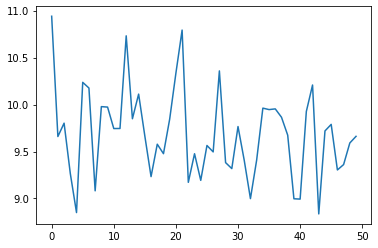

In [1]:
import random

import torch
import torch.nn as nn
import torch.utils.data as Dataset
import matplotlib.pyplot as plt


from torch.optim import lr_scheduler
import torch.optim as optim
from center_loss import CenterLoss

from torchvision import datasets, transforms
from torch import utils
# Data preparation
CUDA = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
batch_size = 128
learning_rate = 1e-3
epochs = 50


data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.ImageFolder('drive/MyDrive/ML_Sp21_Project/100_WebFace', transform=data_transform)
train_length = int(0.8 * len(dataset))
valid_length = len(dataset) - train_length
train, valid = utils.data.random_split(dataset=dataset, lengths=[train_length, valid_length])
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, **kwargs)


# Network Buildup
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*7*7, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Linear(2048, num_classes)
        )
        if init_weights:
            self._initialize_weights()
 
    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x
 
    def _initialize_weights(self):
        for m in self.modules():  # 遍历网络的每一个字模块
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)  # 初始化权重参数
                if m.bias is not None:  # 如果采用了偏置的话，置为0
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
 
 
def make_features(cfg: list):  # 注意这里是 用一个函数把卷积层和池化层堆叠到layers中
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)
 
 
cfgs = { # 论文中的A B D E
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
 
 
def vgg(model_name="vgg11", **kwargs):
    try:
        cfg = cfgs[model_name]
    except:
        print("Warning: model number {} not in cfgs dict!".format(model_name))
        exit(-1)
    model = VGG(make_features(cfg), **kwargs)
    return model


# Define Contrastive Loss



model = vgg('vgg11', num_classes=2, init_weights=True)
# print(model)
if CUDA:
    model.cuda()
loss_function = CenterLoss(num_classes=100, feat_dim=2, use_gpu=CUDA)
optimizer = torch.optim.SGD(loss_function.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.2)


epoches = []
test_losses = []
torch.cuda.empty_cache()
# Start Training
for epoch in range(epochs):
    print('Epoch {}'.format(epoch+1))
    for step, (batch_x, batch_y) in enumerate(train_loader):
        if CUDA:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        embedding = model.forward(batch_x)
        loss = loss_function(embedding, batch_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        print('train loss {:.6f}'.format(loss))

    test_loss = 0
    for batch_x, batch_y in test_loader:
        if CUDA:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        with torch.no_grad():
            embedding = model(batch_x)
        test_loss += loss_function(embedding, batch_y)
    test_losses.append(test_loss.item())
    epoches.append(epoch)
    print('test loss {:.6f}'.format(test_loss))
    print()
    torch.cuda.empty_cache()
plt.plot(epoches, test_losses)
plt.savefig('test_loss.png')

In [2]:
def getColor():
    color: int
    color1 = random.randint(16, 255)
    color2 = random.randint(16, 255)
    color3 = random.randint(16, 255)
    color1 = hex(color1)
    color2 = hex(color2)
    color3 = hex(color3)
    ans = "#" + color1[2:] + color2[2:] + color3[2:]
    return ans


colors = [getColor() for i in range(100)]
train_x = []
train_y = []
train_color = []
test_x = []
test_y = []
test_color = []


for (batch_x, batch_y) in train_loader:
    if CUDA:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
    with torch.no_grad():
        embedding = model(batch_x)
    # print(embedding)
    for i in range(embedding.shape[0]):
        train_x.append(embedding[i][0].item())
        train_y.append(embedding[i][1].item())
        train_color.append(colors[batch_y[i].item()])



for (batch_x, batch_y) in test_loader:
    if CUDA:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
    with torch.no_grad():
        embedding = model(batch_x)
    # print(embedding)
    for i in range(embedding.shape[0]):
        test_x.append(embedding[i][0].item())
        test_y.append(embedding[i][1].item())
        test_color.append(colors[batch_y[i].item()])

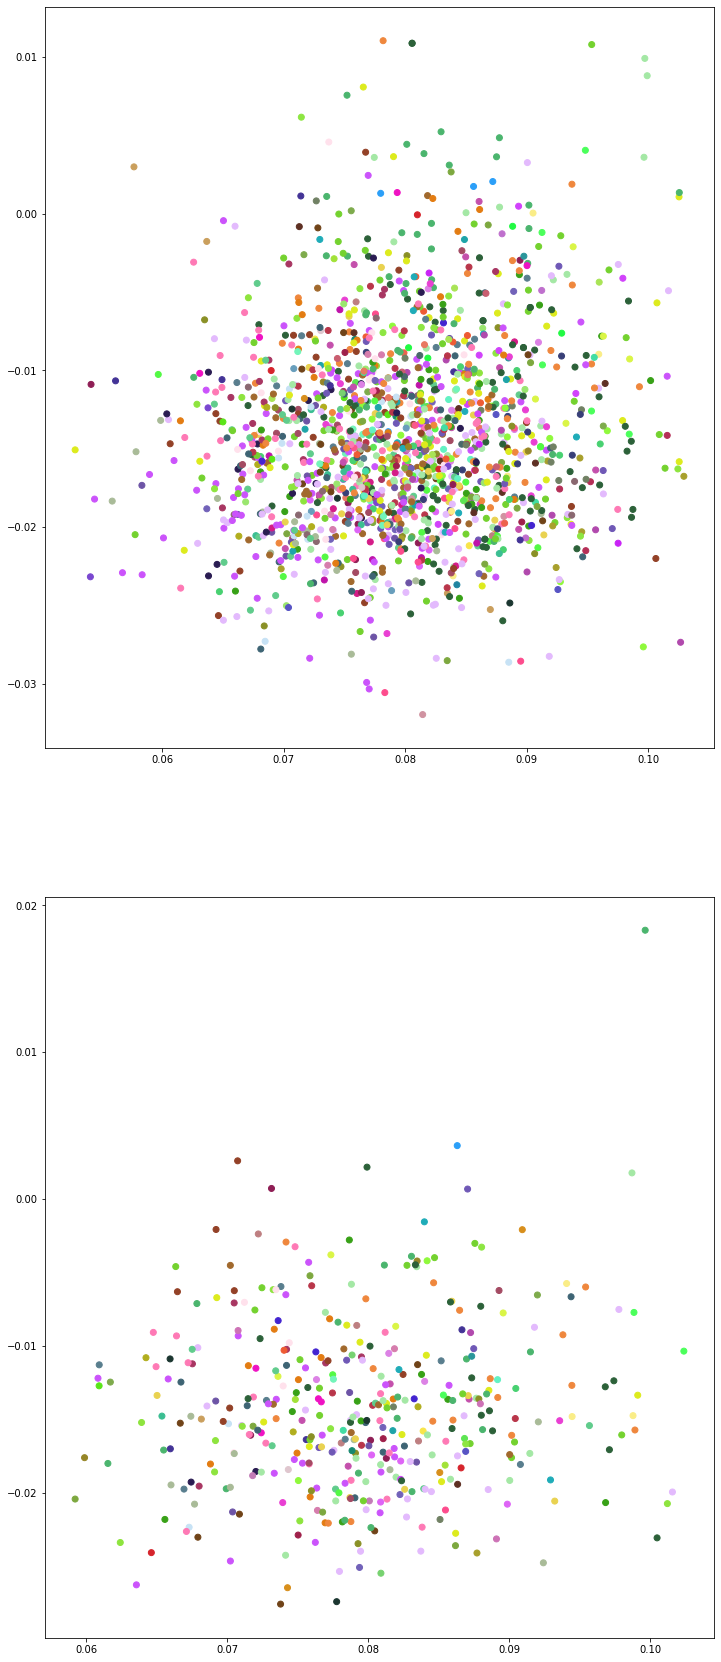

In [14]:
plt.figure(figsize=(12, 30))
plt.subplot(2, 1, 1)
plt.scatter(train_x, train_y, c=train_color)
plt.savefig('train.png')
plt.subplot(2, 1, 2)
plt.scatter(test_x, test_y, c=test_color)
plt.savefig('test.png')